In [1]:
import numpy as np

from astropy import coordinates
from astropy import units as u
from astropy.coordinates import CartesianRepresentation, CartesianDifferential, GCRS, ITRS, EarthLocation

In [39]:
## Q2 ##
## ECI to orbit plane coordinates ##

# Define the position and velocity vectors in ECI coordinates
r_eci = [-346, 8265, 4680] # km
v_eci = [-2.657, -1.73, 2.703] # km/s

# Define the Earth location
lat = 0 * u.deg
lon = 0 * u.deg
height = 0 * u.m
earth_loc = EarthLocation.from_geodetic(lon, lat, height)

# Define the time of observation
time_obs = 'J2000'

# put velocities into cartesian differential
cartdiff = coordinates.CartesianDifferential(*v_eci, unit='km/s')
cartrep = coordinates.CartesianRepresentation(*r_eci, unit='km', differentials=cartdiff)

# Convert GCRS to ITRS
gcrs = coordinates.ITRS(cartrep, obstime=time_obs)
itrs = gcrs.transform_to(coordinates.GCRS(obstime=time_obs))

itrs_pos = itrs.cartesian.xyz
itrs_vel = itrs.cartesian.differentials

# Define the angular momentum vector and the z-axis vector
h = np.cross(itrs_pos, itrs_vel['s'].get_d_xyz(xyz_axis=0).value)
z = np.array([0, 0, 1])

# Define the perifocal coordinate system
x = np.cross(h, z)
y = np.cross(z, x)

# Define the transformation matrix from ECI to perifocal coordinates
eci_to_perifocal = np.vstack((x.value, y.value, z))

# Convert the position and velocity vectors from ECI to perifocal coordinates
r_perifocal = eci_to_perifocal.dot(itrs_pos.value)
r_perifocal = r_perifocal * np.linalg.norm(itrs_pos.value) / np.linalg.norm(r_perifocal)
v_perifocal = eci_to_perifocal.dot(itrs_vel['s'].get_d_xyz(xyz_axis=0).value)
v_perifocal = v_perifocal * np.linalg.norm(itrs_vel['s'].get_d_xyz(xyz_axis=0).value) / np.linalg.norm(v_perifocal)

# Print the results
print('Position in perifocal coordinates (m/s):', r_perifocal)
print('Velocity in perifocal coordinates (m/s):', v_perifocal)



Position in perifocal coordinates (m/s): [-8.42980126e+03 -4.38985098e+03  1.59355315e-01]
Velocity in perifocal coordinates (m/s): [ 3.68076474e+00 -2.73214564e+00  9.91792046e-05]


[-8.42980126e+03 -4.38985098e+03  1.59355315e-01] [ 3.68076474e+00 -2.73214564e+00  9.91792046e-05]
The minimum altitude during the orbit is: -4008.23 km
The speed at the minimum altitude is: 16.53 km/s
The time at minimum altitude is: 1690.09 s
The maximum altitude during the orbit is: 3126.21 km
The velocity at the maximum altitude is: 4.5840 km/s
The time at maximum altitude is: 0.00 s



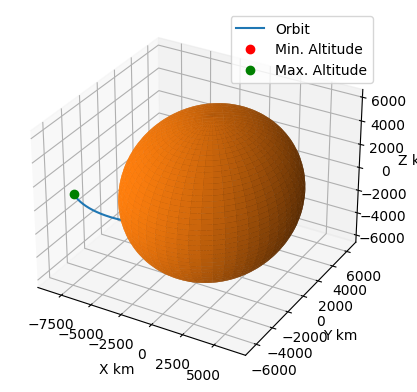

In [92]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401, needed for 3d plots

G = 6.67430e-20  # km**3/(kg * s**2)
m_1 = 5.97219e24  # kg
m_2 = 1000  # kg
mu = G * m_1
R_E = 6378.12  # km

r_0 = r_perifocal # km
v_0 = v_perifocal  # km/s
print(r_0, v_0)
Y_0 = np.hstack((r_0, v_0))

def relative_motion(t, Y):
    """Calculate the motion of a two-body system relative to $m_1$.

    The state vector ``Y`` should be in the order:

    1. Coordinates of $m_2$ relative to $m_1$
    2. Velocity components of $m_2$ relative to $m_1$
    """
    # Get the three position components
    r_vec = Y[:3]

    # Create the derivative vector and copy the velocities into it
    Ydot = np.zeros_like(Y)
    Ydot[:3] = Y[3:]

    # Calculate the accelerations
    r = np.sqrt(np.sum(np.square(r_vec)))
    a_vec = -mu * r_vec / r ** 3
    Ydot[3:] = a_vec

    return Ydot

t_0 = 0  # seconds
t_f = 30*60  # seconds, period of one orbit
t_points = np.linspace(t_0, t_f, 1000)
sol = solve_ivp(relative_motion, [t_0, t_f], Y_0, t_eval=t_points)

Y = sol.y.T
r = Y[:, :3]  # km
v = Y[:, 3:]  # km/s

r_mag = np.sqrt(np.sum(np.square(r), axis=1))
# altitude is the distance above the surface of the Earth
altitude = r_mag - R_E

speed = np.sqrt(np.sum(np.square(v), axis=1))

min_altitude = np.min(altitude)
i_min = np.argmin(altitude)

max_altitude = np.max(altitude)
i_max = np.argmax(altitude)

speed_at_min_alt = speed[i_min]
speed_at_max_alt = speed[i_max]
time_at_min_alt = sol.t[i_min]
time_at_max_alt = sol.t[i_max]

print(
    f"""\
The minimum altitude during the orbit is: {min_altitude:.2F} km
The speed at the minimum altitude is: {speed_at_min_alt:.2F} km/s
The time at minimum altitude is: {time_at_min_alt:.2F} s
The maximum altitude during the orbit is: {max_altitude:.2F} km
The velocity at the maximum altitude is: {speed_at_max_alt:.4F} km/s
The time at maximum altitude is: {time_at_max_alt:.2F} s
"""
)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot(r[:, 0], r[:, 1], r[:, 2], label="Orbit")
ax.set_xlabel("X km")
ax.set_ylabel("Y km")
ax.set_zlabel("Z km")

# This adds a sphere to the plot of the radius of the Earth
p = np.linspace(0, np.pi, 200)
t = np.linspace(0, 2 * np.pi, 200)
P, T = np.meshgrid(p, t)

X = R_E * np.cos(T) * np.sin(P)
Y = R_E * np.sin(T) * np.sin(P)
Z = R_E * np.cos(P)

ax.plot_surface(X, Y, Z)
ax.plot(r[i_min, 0], r[i_min, 1], r[i_min, 2], "ro", label="Min. Altitude")
ax.plot(r[i_max, 0], r[i_max, 1], r[i_max, 2], "go", label="Max. Altitude")
ax.legend()




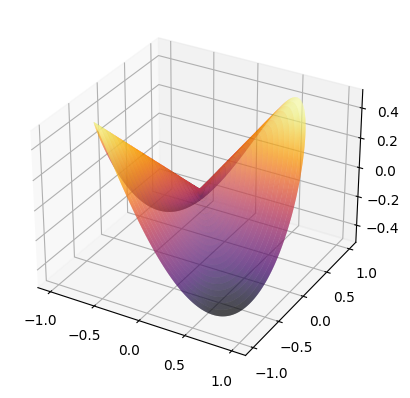

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

## to maximize rendering speed, we want the parameters rstride and cstride 
## to be multiples of the number of rows-1 and columns-1
r=np.linspace(0,1,101)
theta=np.linspace(0,2*np.pi,10001)
R,Theta=np.meshgrid(r,theta)
X,Y=R*np.cos(Theta),R*np.sin(Theta)
Z=R*np.sin(Theta)*np.cos(Theta)

fig=plt.figure(1)
ax=fig.add_subplot(projection='3d')
ax.plot_surface(X,Y,Z,rstride=5,cstride=5,cmap=cm.inferno,linewidth=0)
plt.show()